# Advanced Scoring of Graded Readers
## DS 7337 - Natural Language Processing - Homework 2
### George C. Sturrock
### January 26, 2019
#### Homework 2 Objectives
1.	In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. 
2.	After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.
3.	Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts used in homework 1.

#### Import Libraries

In [87]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request

import nltk; print("NLTK Version:", nltk.__version__)
from nltk.corpus import stopwords
theStopWords = set(stopwords.words('english'))

import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
import matplotlib.pyplot as plt; #print("Matplotlib Pyplot Version:", plt.__version__)
import string; #print("String Version:", string.__version__)

import seaborn as sns; print("Seaborn Version:", sns.__version__)
sns.set(style='darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup; print("BeatifulSoup Version: 4.6.3")

Platform: Linux-4.15.0-1026-gcp-x86_64-with-debian-stretch-sid
Python: 3.5.6 |Anaconda custom (64-bit)| (default, Aug 26 2018, 21:41:56) 
[GCC 7.3.0]
Requests: 2.19.1
NLTK Version: 3.3
Numpy Version: 1.15.2
Pandas Version: 0.23.4
Seaborn Version: 0.9.0
BeatifulSoup Version: 4.6.3


#### Scrape Gutenberg Website for Links to Text Documents for Graded Readers
The base site for text mining is the Gutenberg Children's Instructional Bookshelf.  This page contains the links for various readers for children of various ages and reading levels.  Specifically, the Graded Readers section appears on this site.  The Graded Readers will be the focus of text analysis in this paper.  The first step is manually scraping the page for document links is to read the URL and parse the HTML code the links to the documents.  This process shown below creates a list with links to documents in the Children's Instructional Bookshelf.  

In [183]:
#retrieve html text
base_url = "http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)"
response = requests.get(base_url)

#Search text for links to Gutenberg Readers
soup = BeautifulSoup(response.text, 'html.parser')
base_url_level1_href_tags = []
base_url_level1_href_tags = ["http:" + tag.attrs['href'] for tag in soup.find_all(href=True, class_='extiw')]

#Construct Links to Reader Text Documents
urlroot = "http://www.gutenberg.org/cache/epub/"

try:
    del urllist
except Exception as e:
    print(e)

urllist = list()

for b in base_url_level1_href_tags:
    docnum = (b.split('/'))[-1]
    urllist.append(urlroot+docnum+"/pg"+docnum+".txt")

#### Function to Transform Web Content to NLTK Tokens
The "nlpPipe" function create a code pipeline to transform html text into a tokenized set of words.  The pipeline removes punctuation, most licensing information, standard stop words as defined by NLTK and changes all text to lower case.  This functions returns the base information needed to productin the calculations specified in Homework 2's objectives.  

In [184]:
#credit to:
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

strip = list()
table = str.maketrans('', '', string.punctuation)
#nlpdf = pd.DataFrame(columns=["Title", "VocabSize"])

def nlpPipe(htmlIn):
    #split html into lines
    html2 = htmlIn.splitlines()
    #Strip licensing from htmlIn
    #start = [i for i, s in enumerate(html2) if s.startswith("CONTENTS")]
    start = [i for i, s in enumerate(html2) if s.startswith("*** START OF THIS PROJECT GUTENBERG EBOOK") 
             or s.startswith("*** START OF THE PROJECT GUTENBERG EBOOK")
             or s.startswith("***START OF THE PROJECT GUTENBERG EBOOK")]
    end = [i for i, s in enumerate(html2) if s.startswith("*** END OF THIS PROJECT GUTENBERG EBOOK") 
           or s.startswith("*** END OF THE PROJECT GUTENBERG EBOOK")
           or s.startswith("***END OF THE PROJECT GUTENBERG EBOOK")]
    text = html2[(start[0]+1):(end[0]-2)]
    
    #strip end of line characters and convert to lower case
    for t in text:
        strip.append(t.rstrip().lower())
    
    #remove punctuation, remove stopwords with lambda functions and tokenize result
    raw = nltk.word_tokenize(str(strip))
    raw2 = [r.translate(table) for r in raw]
    rawx = [rx for rx in raw2 if rx not in theStopWords and rx.isalpha()]
    raw3 = nltk.Text(rawx)
    raw4 = raw3.tokens
    return raw4, html2[0], (len(set(raw4)));

#### Process Text from URLs
The full set of URLs generated from scraping the Children's Instructional Bookshelf page are filtered to focus on the Graded Readers.

In [185]:
#all graded readers
urllist = urllist[11:31]
#urllist

Download Graded Reader texts and submit the to the nlpPipe function for processing.  The base dataframe "calcdf" for storing the results is created as well.  Two of the URLs do not conform to the structure of the other Graded Readers on the site.  Special programming can be included for these two documents.  For the purposes of this study, any text which does not conform to majority URL stucture will be ignored as the represent a relatively small percentage of the overall set of documents.  The texts are naturally ordered from what is expected to be least difficult to most difficult.

In [186]:
calcdf = pd.DataFrame(columns=["Title", "VocabSize", "LongWord", "UniqueWords"])

for u in urllist:
    #print(u)
    
    try:
        html = request.urlopen(u).read().decode('utf8')
    except Exception as e:
        print(e, u)
        
    tokens, title, unique = nlpPipe(html)
    
    #loop to identify and count words longer than 10 characters
    longword = 0
    for t in tokens:
        if len(t) > 10:
            longword += 1
    
    calcdf = calcdf.append({"Title": title[31:], "VocabSize": len(tokens), "LongWord": longword, "UniqueWords": unique}, 
                           ignore_index=True)
    
#calcdf

HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/13853/pg13853.txt
HTTP Error 404: Not Found http://www.gutenberg.org/cache/epub/22795/pg22795.txt


#### Calculations
Normalized Vocabulary Size, Lexical Diversity, Normalized Long Words and Text Difficulty are calculated below.  The calculations are simple operations which return interesting measurements to assist with comparing Graded Reader texts.

In [187]:
calcdf["NormVocabSize"] = (calcdf.VocabSize / calcdf.VocabSize.max())
calcdf["LexDiversity"] = (calcdf.UniqueWords / calcdf.VocabSize)
calcdf["NormLongWord"] = (calcdf.LongWord / calcdf.LongWord.max())
calcdf["TextDifficulty"] = ((calcdf.NormVocabSize + calcdf.LexDiversity + calcdf.NormLongWord)/3)
calcdf

,Title,VocabSize,LongWord,UniqueWords,NormVocabSize,LexDiversity,NormLongWord,TextDifficulty
0,"The Beacon Second Reader, by James H. Fassett",11625,128,3357,0.0156921,0.288774,0.00646301,0.103643
1,The Child's World,29305,347,5364,0.0395576,0.18304,0.0175208,0.0800396
2,De La Salle Fifth Reader,57378,910,9443,0.0774521,0.164575,0.045948,0.0959918
3,"The Elson Readers, Book 5",117820,2037,13945,0.15904,0.118359,0.102853,0.126751
4,"The Literary World Seventh Reader, by Various",169950,3542,18254,0.229408,0.107408,0.178844,0.171887
5,"McGuffey's First Eclectic Reader, Revised",174041,3631,18396,0.234931,0.105699,0.183338,0.174656
6,McGuffey's Second Eclectic Reader,183030,3787,18661,0.247064,0.101956,0.191214,0.180078
7,McGuffey's Third Eclectic Reader,196081,3899,18946,0.264681,0.0966233,0.196869,0.186058
8,McGuffey's Fourth Eclectic Reader,227810,4552,20718,0.307511,0.0909442,0.229841,0.209432
9,McGuffey's Fifth Eclectic Reader,277571,6059,23548,0.374681,0.084836,0.305933,0.25515


### Question 1 - Scoring the Vocabulary Size of a Text
The raw vocabulary size of each text (calcdf.VocabSize) is represented by the count of words in each text as identified by the nlpPipe function.  This is normalized on a 0 to 1 scale by dividing the "VocabSize" by the maximum "VocabSize" from the dataframe.  The results are stored in calcdf.NormVocabSize.  The box plots below shows this small sample of texts has a slight right skew with median value of approximately 0.4.  The barchart shows how the individual texts rank with regards to normalized vocabulary size.  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

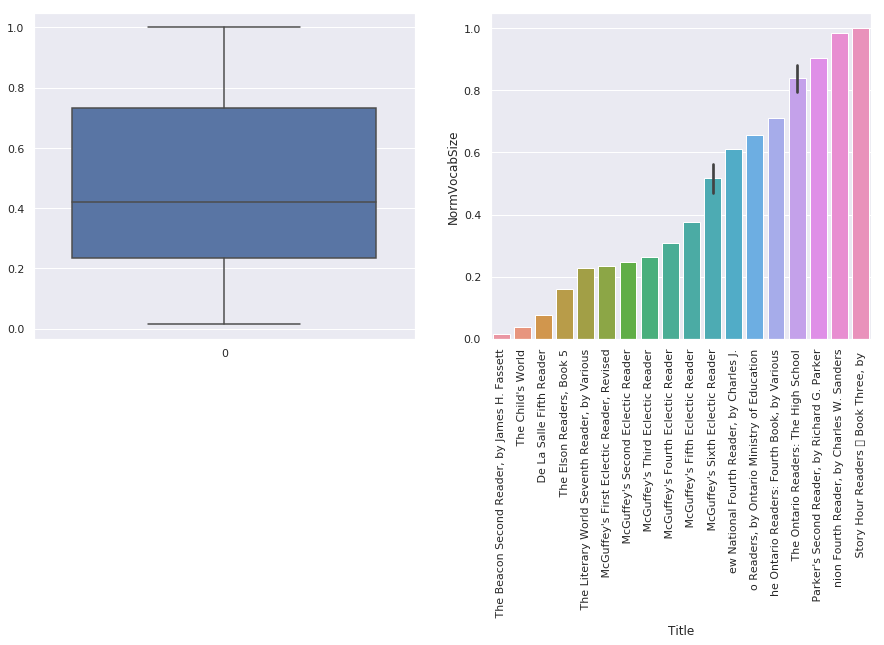

In [188]:
f, axes = plt.subplots(1,2, figsize=(15,6))

b = sns.boxplot(data=calcdf.NormVocabSize, ax = axes[0])
a = sns.barplot(data=calcdf, x='Title', y='NormVocabSize', ax = axes[1])
plt.xticks(rotation=90)

### Question 2 - Normalized Long-Word Vocabulary Size
For purposes of this study, a long word is any word over 10 characters.  This number was obtained by taking the word length of the average word in English, which is approximately five characters, and doubling it.  The number of long words in each text are counted and stored in calcdf.LongWord.  The number of long words per text is then divided by the maximum long word value in calcdf to produce the normalized long word score.  Visual examination of the Normalized Long Word column shows the number of long words increase from observation 0 to 19.  The scatterplot shown below plot the relationship between Normalized Vocabulary Size and Normalized Long Word.  As expected, an almost perfect linear relationship between the two vectors exists.  

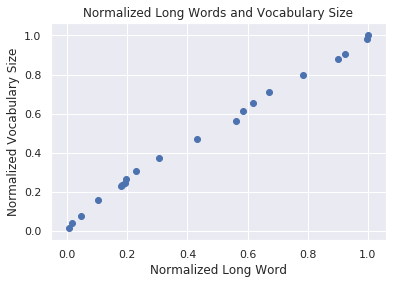

In [189]:
plt.scatter(calcdf.NormLongWord, calcdf.NormVocabSize)
plt.title("Normalized Long Words and Vocabulary Size")
plt.xlabel("Normalized Long Word")
plt.ylabel("Normalized Vocabulary Size")
plt.show()

### Question 3 - Text Difficulty Score
The text difficulty score combines the lexical diversity score from Homework 1 with the normalized long word and normalized vocabulary size introduced in this assignment.  The three variables are added together and divided by three to produce an evenly weighted result.  In Homework 1, McGuffey's First, Third and Sixth Eclectic Readers where analyzed.  These show Lexical Diversity decreases as vocabulary size increases.  The sliced dataframe shown below shows an inverse relationship between Lexical Diversity and Text Difficulty for the three texts analyzed in Homework 1.  

In [190]:
calcdf.iloc[[5,7,10]]

,Title,VocabSize,LongWord,UniqueWords,NormVocabSize,LexDiversity,NormLongWord,TextDifficulty
5,"McGuffey's First Eclectic Reader, Revised",174041,3631,18396,0.234931,0.105699,0.183338,0.174656
7,McGuffey's Third Eclectic Reader,196081,3899,18946,0.264681,0.0966233,0.196869,0.186058
10,McGuffey's Sixth Eclectic Reader,347741,8575,27182,0.469401,0.0781674,0.432971,0.326847


Broader examination of the set of Graded Readers ingested above shows a decrease in Lexical Diversity and a general Text Difficulty increase as the expected level of difficulty increases.  The grouped bar plot below displays this relationship.

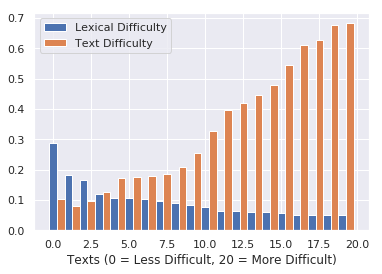

In [191]:
barWidth = 0.5
b1 = np.arange(len(calcdf.LexDiversity))
b2 = [x + barWidth for x in b1]

plt.bar(b1, calcdf.LexDiversity, width=barWidth, label="Lexical Difficulty")
plt.bar(b2, calcdf.TextDifficulty, width=barWidth, label="Text Difficulty")
#plt.bar([x + barWidth for x in b2], calcdf.NormLongWord, width=barWidth, label="Norm Long Word")
plt.xlabel("Texts (0 = Less Difficult, 20 = More Difficult)")
plt.legend()
plt.show()